
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ビジョン用トランスフォーマー

:label: `sec_vision-transformer`

 Transformer アーキテクチャは当初、機械翻訳に重点を置いて、シーケンス間の学習のために提案されました。その後、Transformers がさまざまな自然言語処理タスクで最適なモデルとして登場しました:cite: `Radford.Narasimhan.Salimans.ea.2018,Radford.Wu.Child.ea.2019,brown2020language,Devlin.Chang.Lee.ea.2018,raffel2020exploring` 。ただし、コンピューター ビジョンの分野では、依然として主要なアーキテクチャは CNN (:numref: `chap_modern_cnn` ) です。当然のことながら、研究者たちは、Transformer モデルを画像データに適応させることで、より良い結果が得られるのではないかと考え始めました。この疑問は、コンピューター ビジョン コミュニティに大きな関心を呼び起こしました。最近、:citet: `ramachandran2019stand`畳み込みを自己注意に置き換えるスキームを提案しました。ただし、注意を払って特殊なパターンを使用するため、ハードウェア アクセラレータでモデルをスケールアップすることが困難になります。次に、:citet: `cordonnier2020relationship` 、自己注意が畳み込みと同様の動作を学習できることを理論的に証明しました。経験的には、入力として画像から $2 \times 2$ パッチが取得されましたが、パッチ サイズが小さいため、モデルは低解像度の画像データにのみ適用できます。

パッチ サイズに関する特定の制約がなく、*ビジョン トランスフォーマー*(ViT) は画像からパッチを抽出し、それらを Transformer エンコーダーに入力してグローバル表現を取得し、最終的に分類のために変換されます :cite: `Dosovitskiy.Beyer.Kolesnikov.ea.2021` 。特に、Transformers は CNN よりも優れたスケーラビリティを示します。大規模なデータセットで大規模なモデルをトレーニングする場合、Vision Transformers は ResNets を大幅に上回ります。自然言語処理におけるネットワーク アーキテクチャ設計の状況と同様に、トランスフォーマーはコンピュータ ビジョンにおいても大きな変革をもたらしました。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## モデル

:numref: `fig_vit`ビジョン トランスフォーマーのモデル アーキテクチャを示しています。このアーキテクチャは、画像をパッチするステム、多層の Transformer エンコーダに基づく本体、およびグローバル表現を出力ラベルに変換するヘッドで構成されます。 

![](http://d2l.ai/_images/vit.svg) :ラベル: `fig_vit`

高さ $h$、幅 $w$、および $c$ チャネルを持つ入力画像を考えてみましょう。パッチの高さと幅の両方を $p$ として指定すると、画像は一連の $m = hw/p^2$ パッチに分割され、各パッチは長さ $cp^2$ のベクトルに平坦化されます。このようにして、イメージ パッチは、Transformer エンコーダによってテキスト シーケンス内のトークンと同様に処理できます。特別な「&amp;lt;cls&amp;gt;」 (クラス) トークンと $m$ 平坦化画像パッチは、一連の $m+1$ ベクトルに線形投影され、学習可能な位置埋め込みと合計されます。多層の Transformer エンコーダは、$m+1$ の入力ベクトルを、同じ長さの同じ量の出力ベクトル表現に変換します。 :numref: `fig_transformer`の元の Transformer エンコーダとまったく同じように動作しますが、正規化の位置が異なるだけです。 「&amp;lt;cls&amp;gt;」以降トークンはセルフアテンションを介してすべてのイメージ パッチに対応します ( :numref: `fig_cnn-rnn-self-attention`を参照)。Transformer エンコーダ出力からのその表現はさらに出力ラベルに変換されます。

## パッチの埋め込み

ビジョン Transformer を実装するには、 :numref: `fig_vit`にパッチを埋め込むことから始めましょう。画像をパッチに分割し、これらの平坦化されたパッチを線形投影することは、カーネル サイズとストライド サイズの両方がパッチ サイズに設定される単一の畳み込み演算として簡略化できます。


In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)


次の例では、入力として`img_size`の高さと幅を持つイメージを取得し、パッチ埋め込みにより、長さ`num_hiddens`のベクトルに線形投影された`(img_size//patch_size)**2`パッチが出力されます。


In [3]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X),
                (batch_size, (img_size//patch_size)**2, num_hiddens))


## ビジョントランスフォーマーエンコーダー

:label: `subsec_vit-encoder`

ビジョン Transformer エンコーダの MLP は、元の Transformer エンコーダの位置に関する FFN とはわずかに異なります (:numref: `subsec_positionwise-ffn`を参照)。まず、ここでの活性化関数はガウス誤差線形単位 (GELU) を使用します。これは ReLU :cite: `hendrycks2016gaussian`のより滑らかなバージョンと考えることができます。次に、正則化のために MLP の各全結合層の出力にドロップアウトが適用されます。


In [4]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))


Vision Transformer エンコーダ ブロックの実装は、 :numref: `fig_vit`正規化前の設計に従っており、正規化はマルチヘッド アテンションまたは MLP の*直前に*適用されます。正規化が残差接続*の直後に*配置されるポスト正規化 (:numref: `fig_transformer`の「add &amp; Norm」) とは対照的に、事前正規化はトランスフォーマーのより効果的または効率的なトレーニングにつながります:cite: `baevski2018adaptive,wang2019learning,xiong2020layer` 。


In [5]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))


:numref: `subsec_transformer-encoder`と同様に、ビジョン Transformer エンコーダ ブロックは入力形状を変更しません。


In [6]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)


## すべてを一緒に入れて

以下のビジョン トランスフォーマーの前進パスは簡単です。まず、入力画像が`PatchEmbedding`インスタンスに入力され、その出力が「&lt;cls&gt;」と連結されます。トークンの埋め込み。これらは、ドロップアウトの前に学習可能な位置埋め込みと合計されます。次に、出力は、 `ViTBlock`クラスの`num_blks`インスタンスをスタックする Transformer エンコーダーに供給されます。最後に、「&amp;lt;cls&amp;gt;」の表現です。トークンはネットワークヘッドによって投影されます。


In [7]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])


## トレーニング

Fashion-MNIST データセットでのビジョン Transformer のトレーニングは、CNN が :numref: `chap_modern_cnn`でトレーニングされた方法とまったく同じです。


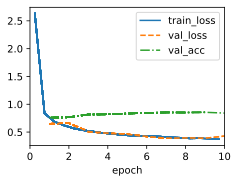

In [8]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)


## 要約と考察

Fashion-MNIST のような小規模なデータセットの場合、実装されたビジョン Transformer は :numref: `sec_resnet`の ResNet よりも優れたパフォーマンスを発揮しないことに気づくかもしれません。 ImageNet データセット (120 万枚の画像) でも同様の観察が可能です。これは、Transformer には、変換不変性や局所性 (:numref: `sec_why-conv` ) などの畳み込みにおける有用な原則が*欠けている*ためです。ただし、大規模なデータセット (例: 3 億画像) で大規模なモデルをトレーニングすると状況が変わり、画像分類においてビジョン Transformers が ResNets よりも大幅に優れており、スケーラビリティにおける Transformers の本質的な優位性が実証されています。:cite: `Dosovitskiy.Beyer.Kolesnikov.ea.2021` · 。 Vision Transformers の導入により、画像データをモデリングするためのネットワーク設計の状況が変わりました。これらは、DeiT :cite: `touvron2021training`のデータ効率の高いトレーニング戦略を使用した ImageNet データセットで効果的であることがすぐに証明されました。ただし、セルフ アテンションの 2 次複雑さ (:numref: `sec_self-attention-and-positional-encoding` ) により、Transformer アーキテクチャは高解像度の画像にはあまり適しません。コンピュータ ビジョンにおける汎用バックボーン ネットワークに向けて、Swin Transformers は画像サイズ (:numref: `subsec_cnn-rnn-self-attention` ) に関する二次計算の複雑さに対処し、畳み込みのような事前分布を追加して、Transformers の適用可能性を拡張しました。最先端の結果による画像分類を超えたコンピューター ビジョン タスクの範囲:cite: `liu2021swin` 。

## 演習
1. `img_size`の値はトレーニング時間にどのように影響しますか?
1.  「&amp;lt;cls&amp;gt;」を投影する代わりにトークン表現を出力に反映する場合、平均化されたパッチ表現を投影するにはどうすればよいですか?この変更を実装して、精度にどのような影響を与えるかを確認してください。
1. ハイパーパラメータを変更してビジョン Transformer の精度を向上させることはできますか?



[ディスカッション](https://discuss.d2l.ai/t/8943)
